## Pupillometry analysis using pupil_labs data in screen stimulation


The idea of this code is to segement temporal windows to analyse how each stimuly might affect pupil size.
The idea is to generate common functions that can serve as an approximation for other analysis, that is:
1) Segment signal by annotations
2) Segmente signal by temporal cues
3) Do mean of signal

Lets start by opennig some data

In [26]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import commons as cm
from data_curation import Normalization
nm=Normalization()


recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S005_PC_EM\data\pupil_labs\006"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)

006/
    annotation.pldata
    annotation_player.pldata
    annotation_player_timestamps.npy
    annotation_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    file_methods.py
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            export_info.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4.canceled
    offline_data/
        annotation_definitions.json
        tokens/
            gaze_positions_consumer_Surface_Tracker_Offline.token
            gaze_positions_consumer_Vis_Polyline.to

In [27]:
pupil_pd_frame.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_y,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle
0,12830.939395,0,1,1.0,0.346181,0.507550,40.744816,2d c++,66.466682,94.550430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12830.939395,0,1,1.0,0.346158,0.507504,40.746780,pye3d 0.3.0 real-time,66.462369,94.559194,...,-0.304857,-0.578464,1.993095,1.880585,-2.488838,129.45118,120.232507,180.659322,180.659322,0.0
2,12830.939528,0,0,1.0,0.593729,0.419005,38.488317,pye3d 0.3.0 real-time,113.995995,111.550954,...,0.461063,-0.875387,1.802541,1.091604,-1.735303,121.91433,70.020059,180.585033,180.585033,0.0
3,12830.939528,0,0,1.0,0.593681,0.418971,38.485771,2d c++,113.986778,111.557625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12830.947384,0,1,1.0,0.345849,0.507333,40.872586,pye3d 0.3.0 real-time,66.403007,94.592065,...,-0.304596,-0.578451,1.999624,1.880311,-2.488923,129.45118,120.232507,180.659322,180.659322,0.0


In [28]:
pupil_pd_frame.columns

Index(['pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'norm_pos_x',
       'norm_pos_y', 'diameter', 'method', 'ellipse_center_x',
       'ellipse_center_y', 'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle',
       'diameter_3d', 'model_confidence', 'model_id', 'sphere_center_x',
       'sphere_center_y', 'sphere_center_z', 'sphere_radius',
       'circle_3d_center_x', 'circle_3d_center_y', 'circle_3d_center_z',
       'circle_3d_normal_x', 'circle_3d_normal_y', 'circle_3d_normal_z',
       'circle_3d_radius', 'theta', 'phi', 'projected_sphere_center_x',
       'projected_sphere_center_y', 'projected_sphere_axis_a',
       'projected_sphere_axis_b', 'projected_sphere_angle'],
      dtype='object')

In [29]:
from IPython.display import display

confidence_thr=0.99

# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

# skip first 5 seconds to allow for the 3D model to converge
# pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]
# pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>confidence_thr)]

filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


# pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
2,12830.939528,0,1.000000,0.593729,0.419005,3.605083
7,12830.947540,0,1.000000,0.594046,0.418899,3.628533
11,12830.955516,0,1.000000,0.594212,0.418462,3.632090
19,12830.971489,0,0.994062,0.594778,0.418520,3.653948
37,12831.011372,0,0.996668,0.594893,0.419343,3.673242
44,12831.027509,0,1.000000,0.594341,0.420149,3.660239
52,12831.043509,0,1.000000,0.594469,0.421198,3.673665
59,12831.051497,0,0.995940,0.594584,0.421179,3.669087
71,12831.075529,0,1.000000,0.597528,0.419961,3.655609
95,12831.123482,0,1.000000,0.482966,0.444230,3.658521


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
1,12830.939395,1,1.0,0.346158,0.507504,3.986191
4,12830.947384,1,1.0,0.345849,0.507333,3.999249
8,12830.955381,1,1.0,0.346215,0.507425,3.979643
13,12830.963390,1,1.0,0.345984,0.507810,3.994772
16,12830.971389,1,1.0,0.345390,0.507457,3.999582
23,12830.979542,1,1.0,0.345285,0.507763,3.994975
24,12830.987356,1,1.0,0.345320,0.508066,4.013421
30,12830.995537,1,1.0,0.344786,0.507772,4.026628
33,12831.003402,1,1.0,0.344647,0.507760,4.029298
38,12831.011509,1,1.0,0.344632,0.508022,4.019791


In [30]:
%matplotlib qt
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

In [31]:
%matplotlib qt
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

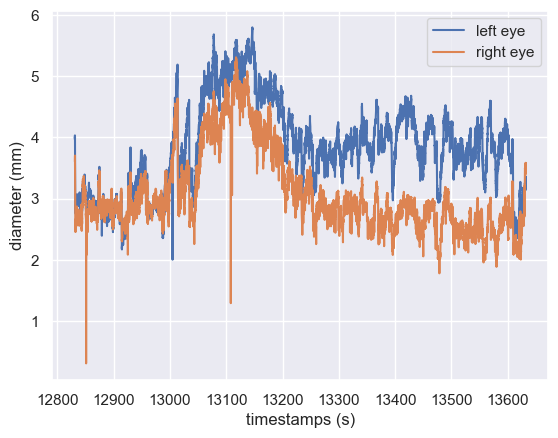

In [32]:
%matplotlib inline

cm.plot_pupillometry_both_eyes(
                                df_left_eye=pupil_left_eye,
                                df_right_eye=pupil_right_eye
)

### Lets do some temporal window filtering


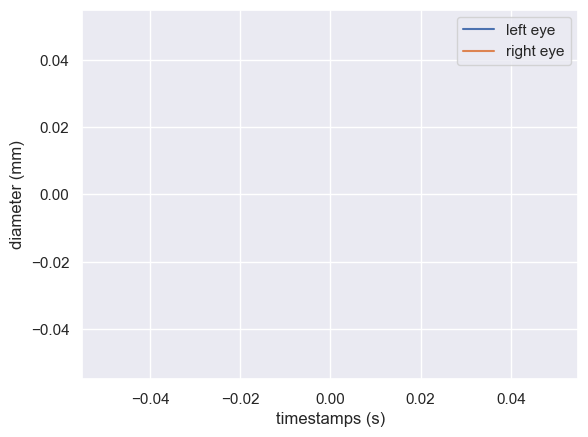

In [33]:
left_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_left_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')

right_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_right_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')



cm.plot_pupillometry_both_eyes(
                                df_left_eye=left_window,
                                df_right_eye=right_window
)

Lets normalize the data in std deviations


C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\3469484839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['diameter_3d']=nm.normalize(values=pupil_left_eye['diameter_3d'],
C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\3469484839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['diameter_3d']=nm.normalize(values=pupil_right_eye['diameter_3d'],


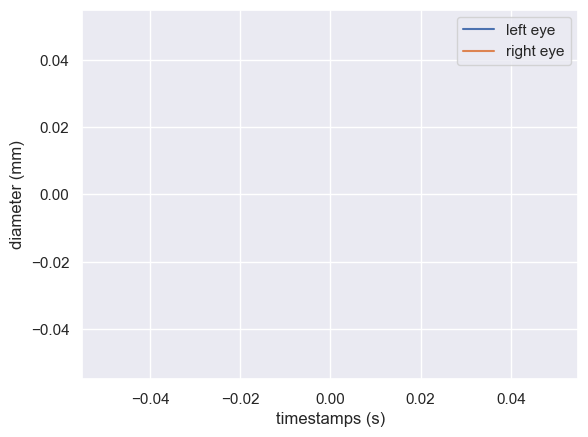

In [34]:
pupil_left_eye['diameter_3d']=nm.normalize(values=pupil_left_eye['diameter_3d'],
                                            type='z_score'
                                            )
pupil_right_eye['diameter_3d']=nm.normalize(values=pupil_right_eye['diameter_3d'],
                                            type='z_score'
                                            )       
left_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_left_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')

right_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_right_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')
cm.plot_pupillometry_both_eyes(
                                df_left_eye=left_window,
                                df_right_eye=right_window
                                )

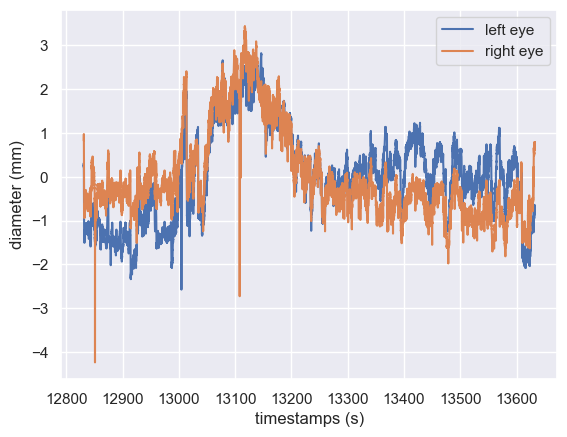

In [35]:
cm.plot_pupillometry_both_eyes(
                                df_left_eye=pupil_left_eye,
                                df_right_eye=pupil_right_eye
                                )

Now the idea is to select the temporal window of each asset and perform the mean

In [36]:
#Lets extract a list with the annotations
images=[]
with open(image_location+'/assets.txt','r') as f:
    for image in f:
        images.append(image.replace('\n',''))
    f.close()


## Lets see the mean pupillometry of all events

In [37]:

pupil_matrix=np.zeros([pupil_left_eye.shape[0],len(images)])


for num,im in enumerate(images):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)

    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_left_eye,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

Text(0.5, 1.0, 'Raw assets and mean pupilometry')

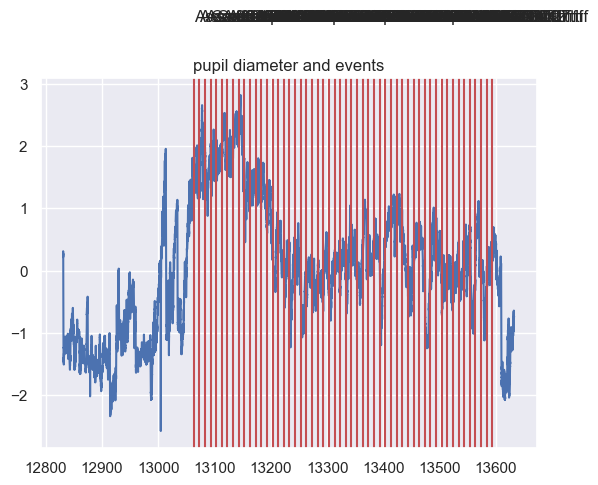

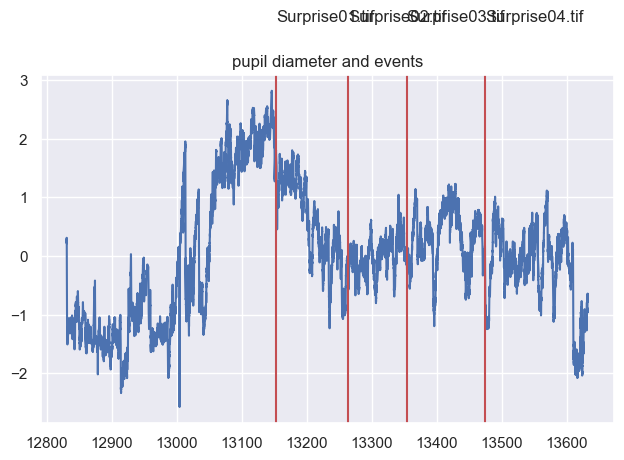

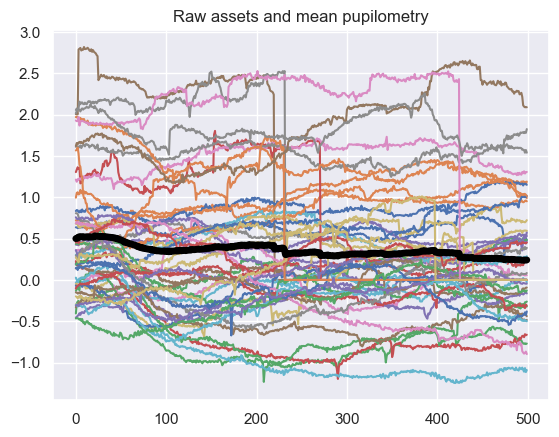

In [38]:
%matplotlib inline
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

fig, ax=plt.subplots(1,1)
ax.plot(pupil_matrix[0:500,:])
ax.plot(np.mean(pupil_matrix[0:500,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry')

In [14]:
images
all_events=annotations_pd.values.flatten()

### Now lets compare assets with surprise assets


In [15]:
#first extract a matrixt with normal assets
event_annotations=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye

pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

#Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

Text(0.5, 1.0, 'Raw assets and mean pupilometry')

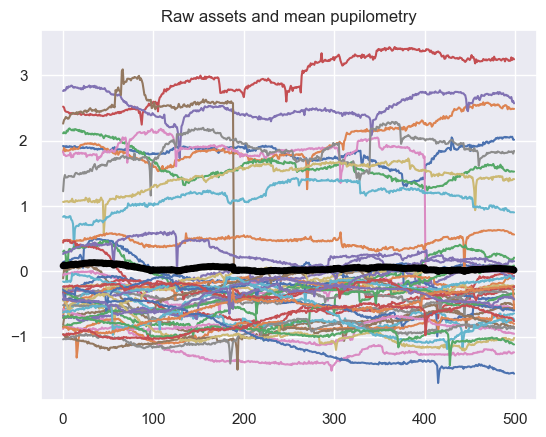

In [16]:
fig, ax=plt.subplots(1,1)
ax.plot(pupil_events_matrix[0:500,:])
ax.plot(np.mean(pupil_events_matrix[0:500,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry')

Text(0.5, 1.0, 'Raw surprise and mean pupilometry')

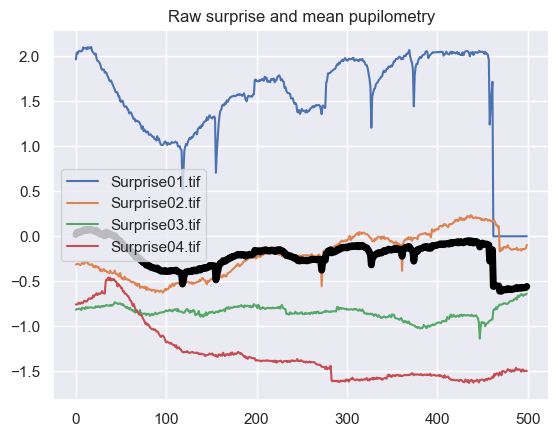

In [17]:
fig, ax=plt.subplots(1,1)
ax.plot(pupil_surprise_matrix[0:500,:])
ax.plot(np.mean(pupil_surprise_matrix[0:500,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry')

Text(0.5, 1.0, 'Mean pupilometry')

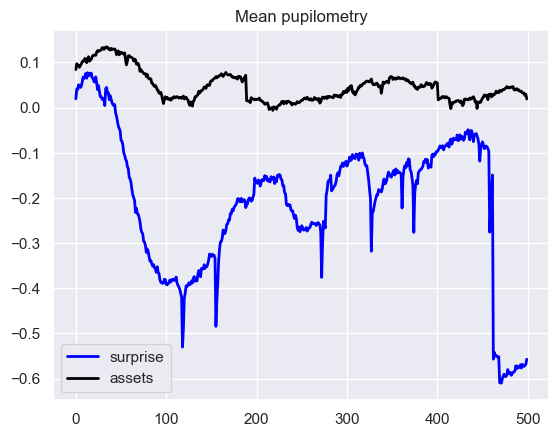

In [18]:
fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_surprise_matrix[0:500,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix[0:500,:],axis=1),linewidth=2,color='black')
ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')

C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\3538598048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=pupil_df['diameter_3d'].diff()


<AxesSubplot: >

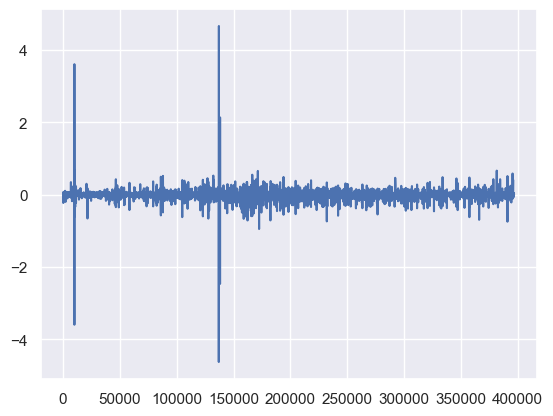

In [19]:
pupil_df['speed']=pupil_df['diameter_3d'].diff()
pupil_df['speed'].plot()

### Since I only have one subject, a good way to maibe reduce dispersion is to meassure the speed of change

In [20]:

event_annotations=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye
pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))
y='speed'
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df[y]

#Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df[y]

#Now extract matrix with blanks

#Now extract matrix with suprise assets
event_annotations=annotations_pd.loc[filter_events_blank,['label']]
pupil_blank_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    print(initial_anotation,end_anotation)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_blank_matrix[0:len(segmented_df),num]=segmented_df[y]


C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\2473410569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))


   index     timestamp    label  duration
0   6736  13058.924854  blank_0       NaN    index     timestamp          label  duration
1   6795  13060.909075  drift_point_0       NaN
   index    timestamp    label  duration
3   7034  13068.92611  blank_1       NaN    index    timestamp          label  duration
4   7094  13070.92588  drift_point_1       NaN
   index     timestamp    label  duration
6   7333  13078.945261  blank_2       NaN    index     timestamp          label  duration
7   7393  13080.943072  drift_point_2       NaN
   index     timestamp    label  duration
9   7632  13088.967072  blank_3       NaN     index     timestamp          label  duration
10   7691  13090.959213  drift_point_3       NaN
    index     timestamp    label  duration
12   7931  13098.974566  blank_4       NaN     index     timestamp          label  duration
13   7990  13100.960275  drift_point_4       NaN
    index     timestamp    label  duration
15   8229  13108.980148  blank_5       NaN     index   

Text(0, 0.5, 'speed (s)')

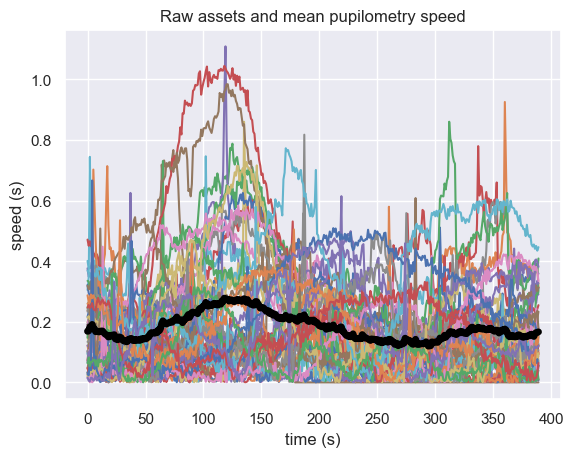

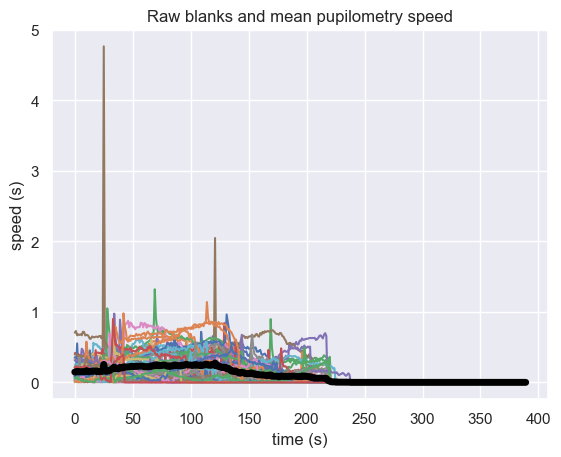

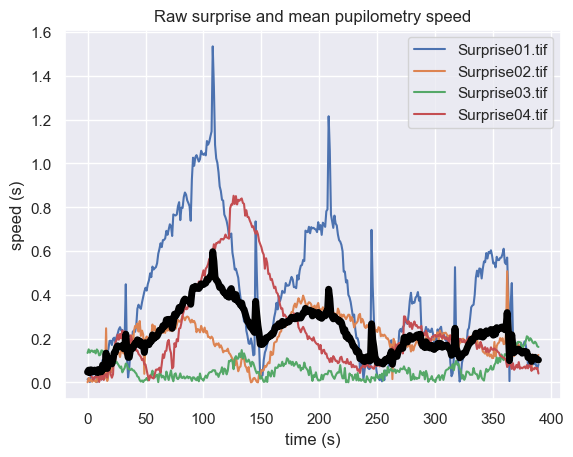

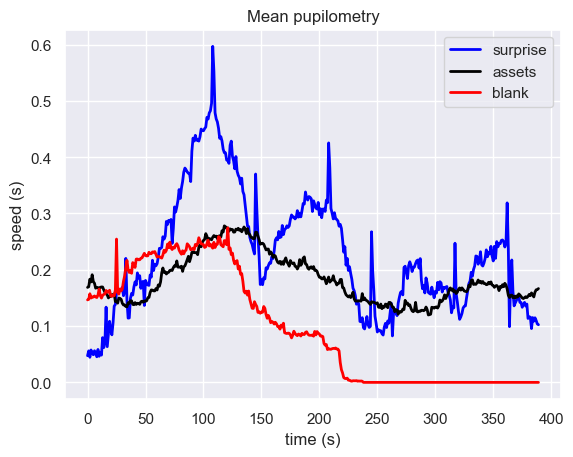

In [21]:
window=range(10,400)

mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_blank_matrix

fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw blanks and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window,:])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')
ax.plot(np.mean(pupil_blank_matrix[window,:],axis=1),linewidth=2,color='red')

ax.legend(['surprise','assets','blank'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Ideas:
1) spectral analysis of frequencies
2) signal processing
3) blank normalization
4) read papers


## what about blank normalization


In [22]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\3297888321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))


0.0941440672057071

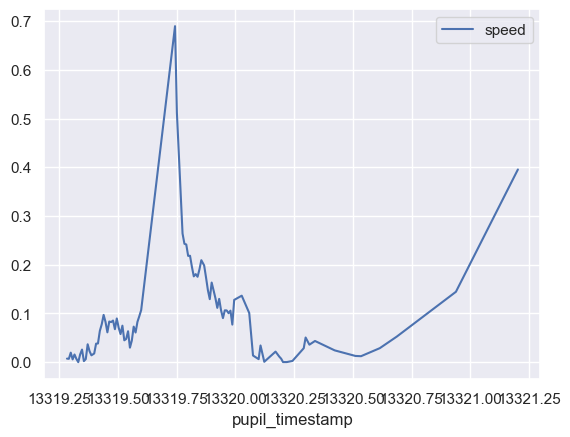

In [23]:

event=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye
pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))
y='speed'



pupil_events_matrix_blank=np.zeros([pupil_df.shape[0],len(event)])
blank_events=[]

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    # print(annotations_pd.iloc[index_annotation],annotations_pd.iloc[index_annotation-1])
    ini_blank=annotations_pd.iloc[index_annotation-1]
    ini_blank_val=annotations_pd.iloc[index_annotation-1,annotations_pd.columns.get_loc('timestamp')].values[0]
    end_blank=annotations_pd.iloc[index_annotation]
    end_blank_value=annotations_pd.iloc[index_annotation,annotations_pd.columns.get_loc('timestamp')].values[0]


    blank_df=cm.filter_rows_by_temporal_values(
                                dataframe=pupil_df,
                                time_column='pupil_timestamp',
                                ini_value=ini_blank_val,
                                end_value=end_blank_value
                                ) 

    blank_mean=abs(blank_df[y].values.mean())
    blank_events.append(blank_mean)
    
    
    if num==21:
        blank_df.plot('pupil_timestamp',y)
        display(blank_mean)


    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix_blank[0:len(segmented_df),num]=segmented_df[y]-blank_mean

# #Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix_blank=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)

    ini_blank=annotations_pd.iloc[index_annotation-1]
    ini_blank_val=annotations_pd.iloc[index_annotation-1,annotations_pd.columns.get_loc('timestamp')].values[0]
    end_blank=annotations_pd.iloc[index_annotation]
    end_blank_value=annotations_pd.iloc[index_annotation,annotations_pd.columns.get_loc('timestamp')].values[0]


    blank_df=cm.filter_rows_by_temporal_values(
                                dataframe=pupil_df,
                                time_column='pupil_timestamp',
                                ini_value=ini_blank_val,
                                end_value=end_blank_value
                                ) 

    blank_mean=abs(blank_df[y].values.mean())
    blank_events.append(blank_mean)
    

    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix_blank[0:len(segmented_df),num]=segmented_df[y]-blank_mean

# #Now extract matrix with blanks

# #Now extract matrix with suprise assets
# event_annotations=annotations_pd.loc[filter_events_blank,['label']]
# pupil_blank_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

# for num,im in enumerate(event_annotations.values.flatten()):
#     initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
#     print(initial_anotation,end_anotation)
#     segmented_df=cm.filter_rows_by_temporal_values(
#         dataframe=pupil_df,
#         time_column='pupil_timestamp',
#         ini_value=initial_anotation['timestamp'].values[0],
#         end_value=end_anotation['timestamp'].values[0]
#         )

#     pupil_blank_matrix[0:len(segmented_df),num]=segmented_df[y]




Text(0, 0.5, 'speed (s)')

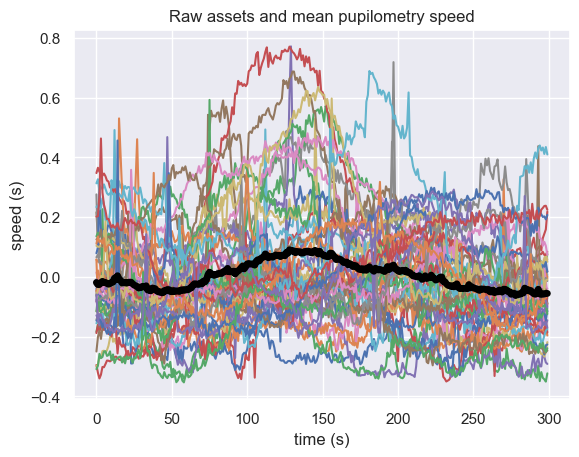

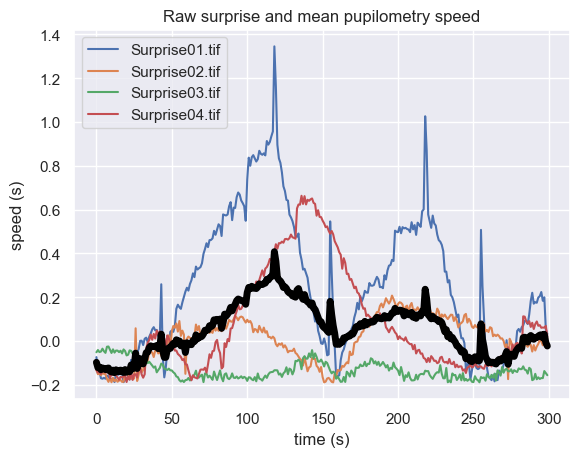

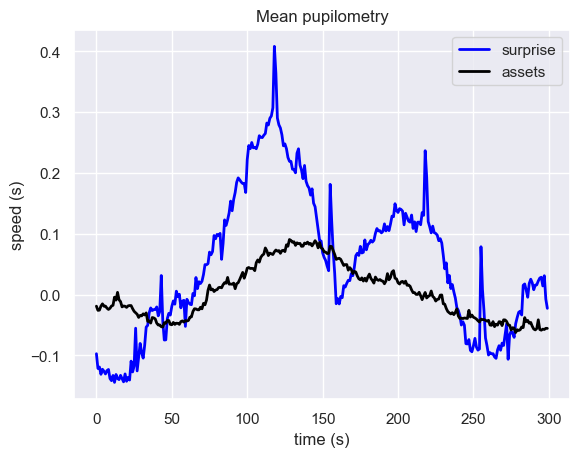

In [24]:
%matplotlib inline
window=range(0,300)


mat=pupil_events_matrix_blank
fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')


mat=pupil_surprise_matrix_blank
fig, ax=plt.subplots(1,1)
ax.plot(mat[window,:])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_surprise_matrix_blank[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix_blank[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets','blank'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Asset normalization

In [25]:

event=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye
pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())
y='speed'
win_norm=range(50)
pupil_events_matrix_blank=np.zeros([pupil_df.shape[0],len(event)])
blank_events=[]

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix_blank[0:len(segmented_df),num]=segmented_df[y]-segmented_df.iloc[win_norm,[segmented_df.columns.get_loc(y)]].mean()#/abs(segmented_df[y].mean())

# #Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix_blank=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    

    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix_blank[0:len(segmented_df),num]=segmented_df[y]-segmented_df[win_norm].mean()#/abs(segmented_df[y].mean())


C:\Users\Bolo\AppData\Local\Temp\ipykernel_12628\3336458187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())


ValueError: could not broadcast input array from shape (687,) into shape (686,)

In [ ]:
r=b[:,None]

In [ ]:
blank_norm=np.mean(pupil_blank_matrix[window,:],axis=0)
blank_norm


array([0.19497611, 0.08598949, 0.36761101, 0.11189169, 0.10334738,
       0.14020873, 0.21343374, 0.18576526, 0.20160305, 0.09610366,
       0.30447701, 0.05833001, 0.19169543, 0.10687313, 0.05875435,
       0.30914009, 0.12099938, 0.22856911, 0.32162223, 0.07813572,
       0.17364469, 0.20207026, 0.37040649, 0.10035629, 0.22426712,
       0.12449422, 0.18824739, 0.40825918, 0.37185215, 0.26415626,
       0.14501229, 0.5739599 , 0.15202637, 0.20621214, 0.3330744 ,
       0.11323997, 0.25662006, 0.36733972, 0.15558483, 0.21418091,
       0.23950479, 0.16548069, 0.15878604, 0.13490143, 0.08817481,
       0.09580891, 0.23988235, 0.31287284, 0.21526481])

In [ ]:
pupil_events_matrix_blank=pupil_events_matrix/blank_norm

ValueError: operands could not be broadcast together with shapes (67325,45) (49,) 

pupil_blank_matrix

pupil_events_matrix_blank=pupil_events_matrix_blank
